In [56]:
using Plots, Random, LinearAlgebra, Statistics

In [2]:
"""plot line y = w*x+b"""
function plotline(w,b;
                  xmin=-100,xmax=100,label="")
    xsamples = [xmin, xmax]
    plot!(xsamples, [w*x+b for x in xsamples], color=:black, label=label)
end

plotline

In [3]:
"""plot function y=f(x)"""
function plotfunc(f;
                  xmin=-100,xmax=100,nsamples=100,label="")
    xsamples = LinRange(xmin,xmax,nsamples)
    plot!(xsamples, [f(x) for x in xsamples], color=:black, label=label)
end

plotfunc

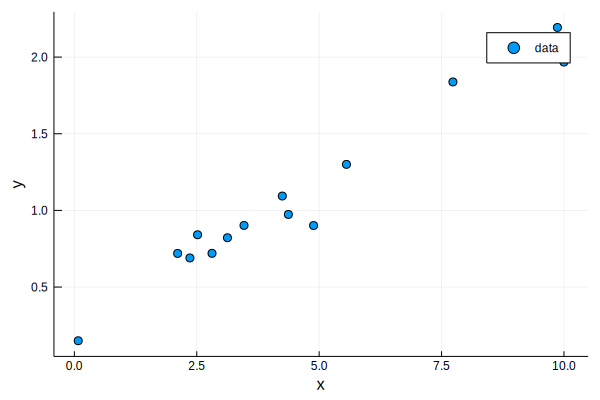

In [4]:
# Generate and plot data
Random.seed!(1)
n = 15
function sample_data(num_points)
    x = rand(num_points)*10
    y = .2 .+ .2*x + .1*sin.(x) + .1*randn(num_points) - .01*((x.-5)/6).^4
    return x,y
end
x,y = sample_data(n)

"""function to plot the above data"""
function plotdata(x=x,y=y; margin=.05)
    scatter(x,y, label="data")
    xlabel!("x")
    ylabel!("y")
    range_y = maximum(y) - minimum(y)
    range_x = maximum(x) - minimum(x)
    ylims!((minimum(y)-margin*range_y,maximum(y)+margin*range_y))
    xlims!((minimum(x)-margin*range_x,maximum(x)+margin*range_x))
end
plotdata()

# Approximating with the mean

In [5]:
# the mean solves a very simple least squares problem:
X = ones(n,1)
w = X\y

1-element Array{Float64,1}:
 1.1418154306154014

In [6]:
# check the solution to our least squares problem is the mean
abs(mean(y) - w[1])

0.0

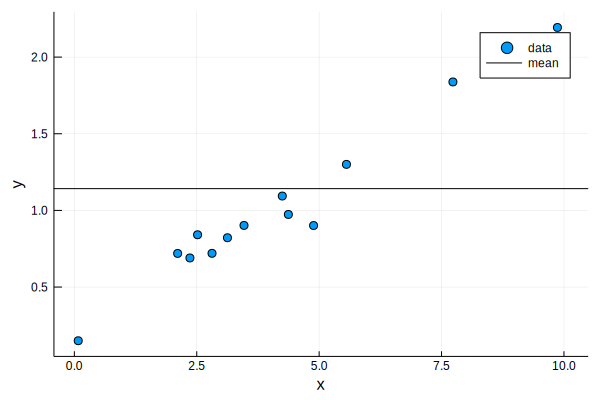

In [7]:
# plot the fit
plotdata()
plotline(0, w[1], label="mean")

# Approximating with a line

In [8]:
X = [copy(x) ones(length(x))]

15×2 Array{Float64,2}:
 2.36033    1.0
 3.46517    1.0
 3.12707    1.0
 0.0790928  1.0
 4.88613    1.0
 2.10968    1.0
 9.51916    1.0
 9.99905    1.0
 2.51662    1.0
 9.86666    1.0
 5.55751    1.0
 4.37108    1.0
 4.24718    1.0
 7.73223    1.0
 2.8119     1.0

In [9]:
w = X\y

2-element Array{Float64,1}:
 0.1889327554101744 
 0.22676530293763508

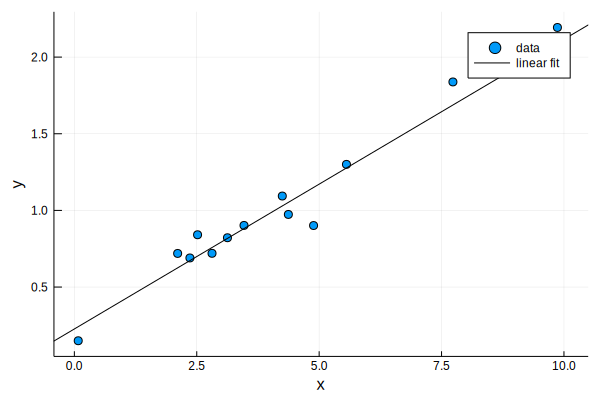

In [10]:
# plot the fit
plotdata()
plotline(w[1], w[2], label="linear fit")

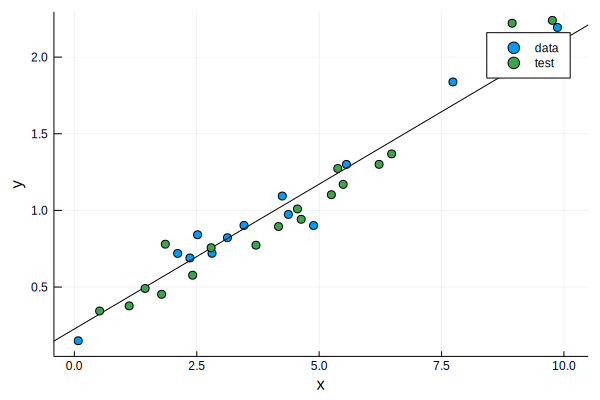

In [11]:
# plot fit on out of sample data
plotdata()
plotline(w[1], w[2])

xtest,ytest = sample_data(20)
scatter!(xtest,ytest,label="test")

# Approximating with a polynomial

In [43]:
# first, construct a Vandermonde matrix
max_order = 10

X = zeros(n, max_order+1)
for k=0:max_order
    X[:,k+1] = x.^k
end
X

20×11 Array{Float64,2}:
 1.0  5.01303   25.1305     125.98       …      1.99943e6        1.00232e7  
 1.0  0.292465   0.0855358    0.0250162         1.56555e-5       4.57868e-6 
 1.0  4.70081   22.0976     103.877             1.12087e6        5.269e6    
 1.0  9.96646   99.3304     989.972             9.70218e8        9.66964e9  
 1.0  8.59268   73.8342     634.433             2.55363e8        2.19425e9  
 1.0  0.431636   0.186309     0.0804177  …      0.000520062      0.000224477
 1.0  1.09001    1.18813      1.29507           2.17211          2.36762    
 1.0  2.97961    8.8781      26.4533        18511.5          55157.0        
 1.0  6.73259   45.3278     305.173             2.8421e7         1.91347e8  
 1.0  4.28342   18.3477      78.591             4.85421e5        2.07926e6  
 1.0  0.866285   0.75045      0.650104   …      0.274757         0.238018   
 1.0  1.079      1.16423      1.25621           1.98236          2.13896    
 1.0  0.469808   0.22072      0.103696          0.00

In [44]:
# solve least squares problem
w = X\y

11-element Array{Float64,1}:
  1.0748412258618962  
 -4.199781574951935   
  7.601361980625852   
 -6.038613629007039   
  2.662105126337397   
 -0.7132042839655658  
  0.12085043823456708 
 -0.013038730118126915
  0.000871086970077305
 -3.30101740425309e-5 
  5.459106800092668e-7

In [58]:
"""computes our polynomial fit evaluated at x"""
function p(x; order = max_order, w = w)
    y = 0
    for k=0:order
        y += w[k+1]*x^k
    end
    return y
end

p

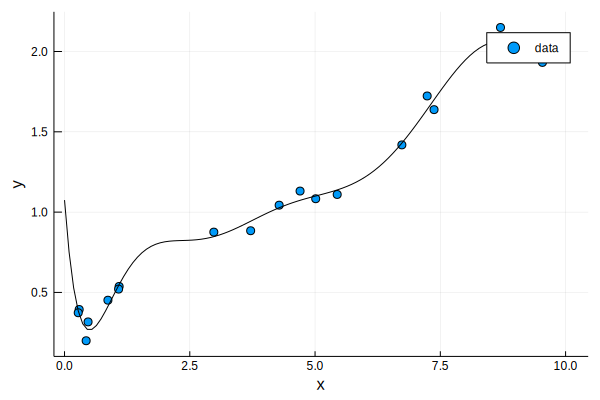

In [46]:
# plot fit
plotdata()
plotfunc(x -> p(x, order=max_order, w=w), xmin=0, xmax=9)

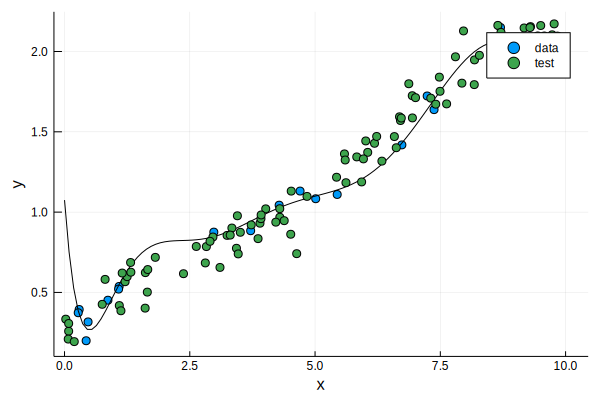

In [47]:
# plot fit on out of sample data
plotdata()
plotfunc(x -> p(x, order=max_order, w=w), xmin=0, xmax=9)

xtest,ytest = sample_data(100)
scatter!(xtest,ytest,label="test")

# Choosing the best model order

In [54]:
max_model_order = 10
rmse = zeros(max_model_order+1) # array to store root mean square model errors
xtest,ytest = sample_data(50)   # generate test set

for model_order = 0:max_model_order
    # form Vandermonde matrix
    X = zeros(n, model_order+1)
    for k=0:model_order
        X[:,k+1] = x.^k
    end
    
    # solve least squares problem
    w = X\y
    
    # compute test error
    ptest = [p(x, order=model_order, w=w) for x in xtest]
    rmse[model_order+1] = mean(abs.(ytest - ptest)) # sqrt(mean((ytest - ptest).^2))
end
rmse

11-element Array{Float64,1}:
 0.539943265461554  
 0.10818644528971084
 0.10840056236108588
 0.10914855359166975
 0.0935525456380928 
 0.0992836754500798 
 0.10130971157038093
 0.10183742618653432
 0.11823647555269368
 0.12841575246176928
 0.1259050737432636 

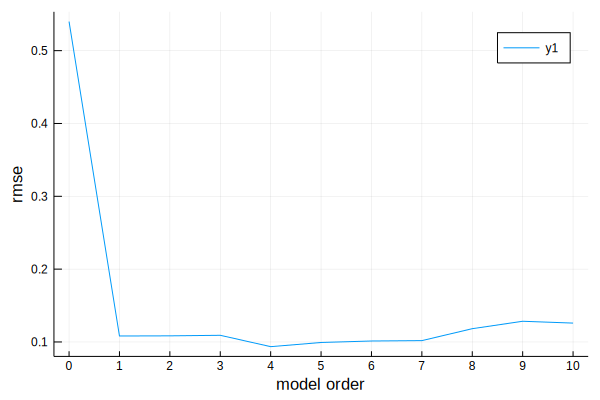

In [55]:
plot(0:max_model_order,rmse)
xticks!(0:10)
xlabel!("model order")
ylabel!("rmse")

# Polynomial models for classification

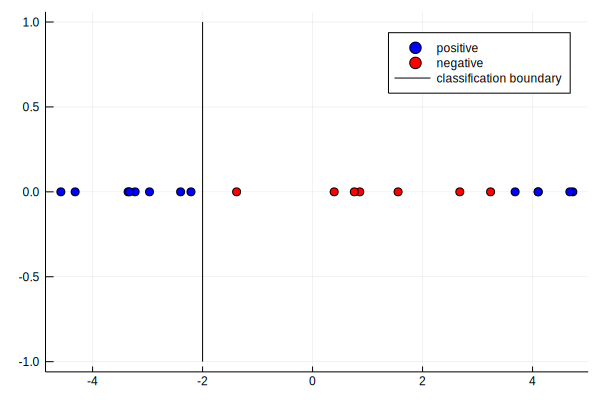

In [19]:
Random.seed!(0)
n = 20
xs = 10*(rand(n) .- .5)
ys = (xs).^2
pos = (xs .- 1).^2 .>= 7
zn=zeros(n)
pt = scatter(xs[pos],zn[pos],color="blue", label="positive")
scatter!(xs[.!pos],zn[.!pos],color="red", label="negative")
plot!([-2,-2], [-1,1], color="black", label="classification boundary")#, ticks=:none, border=:none, legend=false)
yaxis!([-1,1])
savefig("poly-class-1d.pdf")
pt

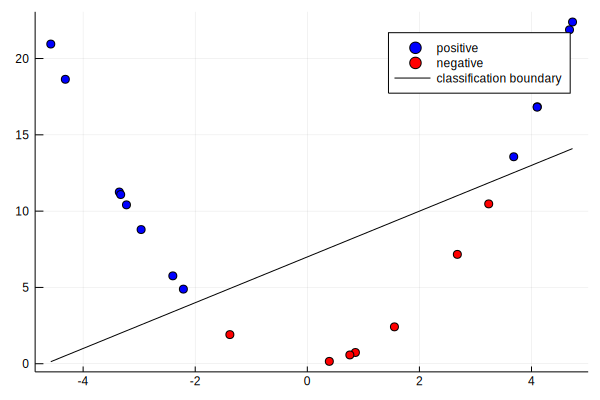

In [20]:
pt = scatter(xs[pos],ys[pos],color="blue", label="positive")
scatter!(xs[.!pos],ys[.!pos],color="red", label="negative")
plot!(xs, 1.5*xs .+ 7, color="black", label="classification boundary")
savefig("poly-class-2d.pdf")
pt

# Bootstrap estimators

In [31]:
# sample K data sets of n samples each and compute a model on each
# see how the models vary
n = 20
K = 100

models = zeros(K,2)
for k=1:K
    xk,yk = sample_data(n) # this experiment samples from the true data distribution many many times (not realistic)
    Xk = [xk ones(n)]
    wk = Xk \ yk
    models[k,:] = wk
end

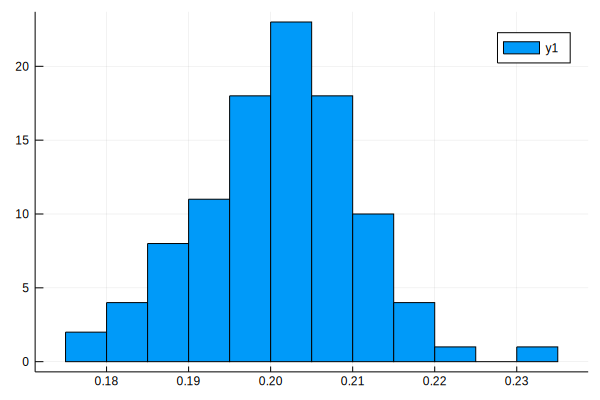

In [32]:
# histogram of the distribution of the first coefficient
# could use to compute, eg, confidence intervals

histogram(models[:,1])

In [33]:
mean(models, dims=1)

1×2 Array{Float64,2}:
 0.200791  0.215193

In [34]:
var(models,dims=1)

1×2 Array{Float64,2}:
 9.04978e-5  0.00314351

In [37]:
# can sample with replacement using rand
rand(1:20, 5)

# eg,
a = .1:.1:2.0
s = rand(1:20, 5)
[s a[s]]

5×2 Array{Float64,2}:
  1.0  0.1
 18.0  1.8
  4.0  0.4
 11.0  1.1
 11.0  1.1

In [38]:
# resample K bootstrap data sets of n samples each and compute a model on each
# see how the models vary
# how does result depend on number of datapoints n? number of resamples K?
n = 20
K = 100

x,y = sample_data(n) # this is the only data we've got!

models = zeros(K,2)
for k=1:K
    mysample = rand(1:n,n)
    xk,yk = x[mysample], y[mysample]
    Xk = [xk ones(n)]
    wk = Xk \ yk
    models[k,:] = wk
end

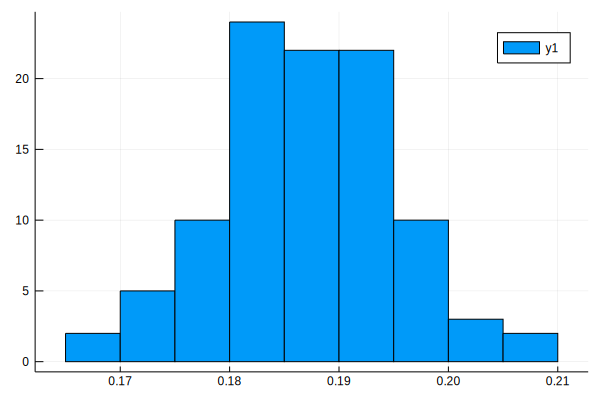

In [39]:
histogram(models[:,1])

In [40]:
mean(models,dims=1)

1×2 Array{Float64,2}:
 0.187231  0.25845

In [41]:
# as K increases, mean of the bootstrap models should converge to 
# the model fit on the original data set
X = [x ones(n)]
w = X \ y

2-element Array{Float64,1}:
 0.18488525755623778
 0.26585715232192225

In [42]:
var(models,dims=1)

1×2 Array{Float64,2}:
 6.39041e-5  0.00115433